<a href="https://colab.research.google.com/github/Aftabgazali/Conditional-GANs-on-MNIST-Dataset/blob/main/Conditional_Gans_on_MNIST_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

## Importing Libraries

In [ ]:
from keras.datasets.mnist import load_data
import matplotlib.pyplot as plt
from numpy import expand_dims
from keras.utils.vis_utils import plot_model
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.models import Model
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

In [ ]:
(trainX, trainY), (testX, testY) = load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
print(trainX.shape)

(60000, 28, 28)


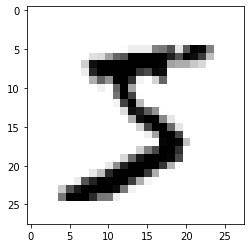

In [ ]:
plt.imshow(trainX[0], cmap ='gray_r')

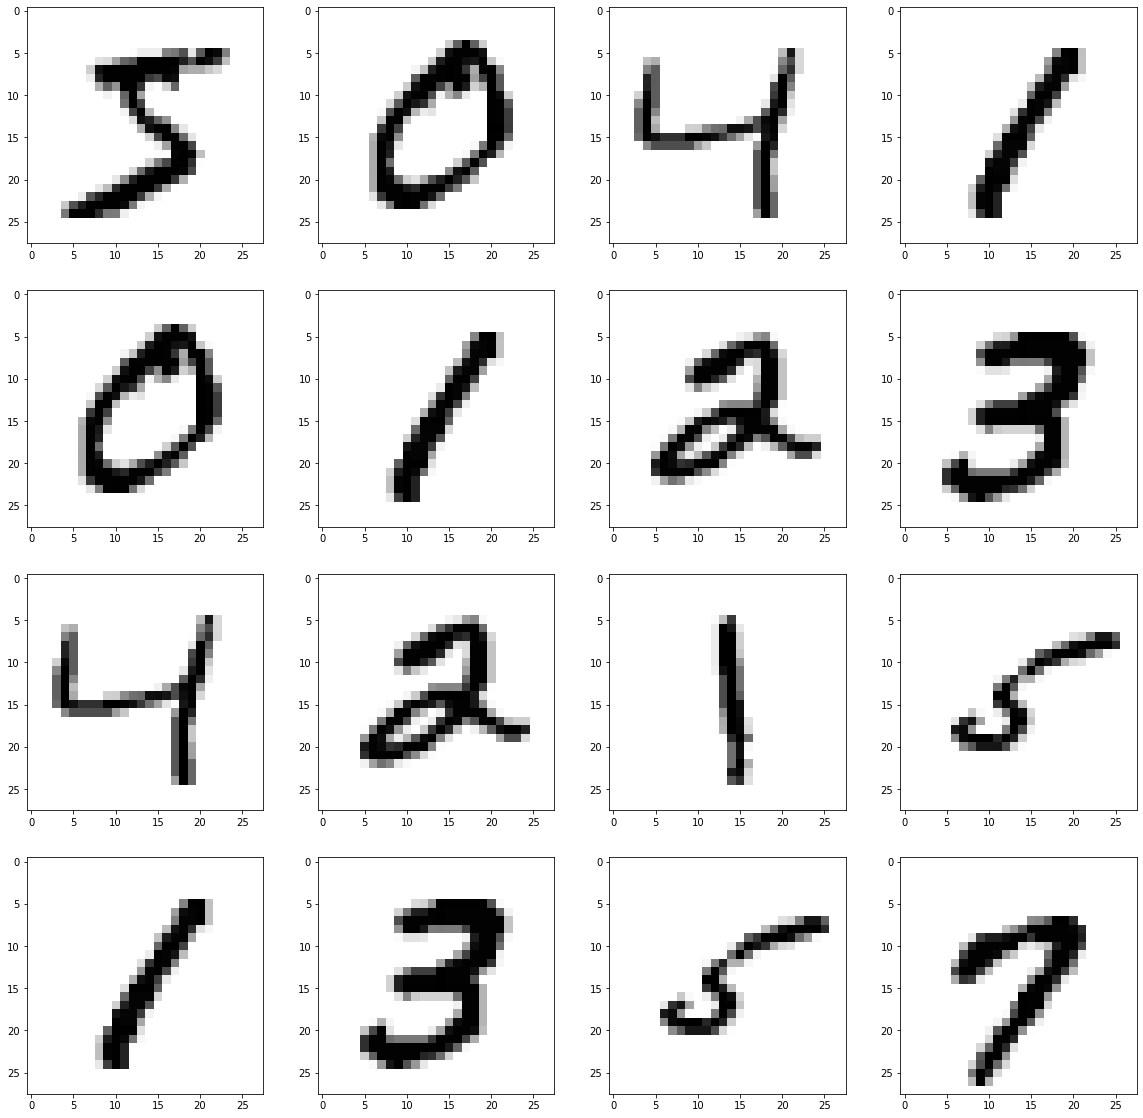

In [ ]:
fig, ax = plt.subplots(ncols = 4, nrows = 4, figsize = (20,20))
for i in range(4):
  for j in range(4):
    ax[i][j].imshow(trainX[(i+1)*(j+1)-1], cmap ='gray_r')

## Define the Discriminator

In [ ]:
def define_discriminator_model(in_shape=(28,28,1)):
  model = Sequential()
  model.add(Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape = in_shape))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (3,3), strides=(2,2), padding ='same'))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

## Define the Generator

In [ ]:
def define_generator_model(latent_dim):
  model = Sequential()
  n_nodes = 128*7*7
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  model.add(Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
  return model

## Define GAN Model

In [ ]:
def define_gan_model(generator, discriminator):
  discriminator.trainable = False
  model = Sequential()
  model.add(generator)
  model.add(discriminator)

  opt = Adam(lr = 0.0002, beta_1= 0.5)
  model.compile(loss = 'binary_crossentropy', optimizer = opt)
  return model


## Preprocessing

In [ ]:
def load_real_samples():
  (trainX, _),(_,_) = load_data()
  X = expand_dims(trainX, axis=-1)
  X = X.astype('float32')
  X = X/255.0
  return X

In [ ]:
def generate_real_samples(dataset, n_samples):
  ix = randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = ones((n_samples, 1))
  return X, y


In [ ]:
def generate_latent_points(latent_dim, n_samples):
  x_input = randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)

  return x_input

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim, n_samples)
  X = generator.predict(x_input)
  y = zeros((n_samples, 1))
  return X, y

In [ ]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
# prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  # save plot
  save_plot(x_fake, epoch)
  # save the generator model tile file
  filename = 'conditional_generator_model_%03d.h5' % (epoch + 1)
  g_model.save(filename)

In [ ]:
def save_plot(examples, epoch, n=10):
  # plot images
  for i in range(n * n):
  # define subplot
    pyplot.subplot(n, n, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    filename = 'conditional_generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

## Training the GAN

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=256):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected ✬real✬ samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)
      # generate ✬fake✬ examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator✬s error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    if (i+1) % 10 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator_model()
# create the generator
generator = define_generator_model(latent_dim)
# create the gan
gan_model = define_gan_model(generator,discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)


In [ ]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
import numpy as np
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
# generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input
# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
  fig, ax = plt.subplots(ncols = 4, nrows =4, figsize= (20,20))
  for i in range(4):
    for j in range(4):
      ax[i][j].imshow(examples[(i+1)*(j+1)-1, :,:,0])

# load model
model = load_model('generator_model_050.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# plot the result
show_plot(X, 10)


# Working on Conditional GANS

## Discriminator Changes

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1, 784)       39984       ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                              

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


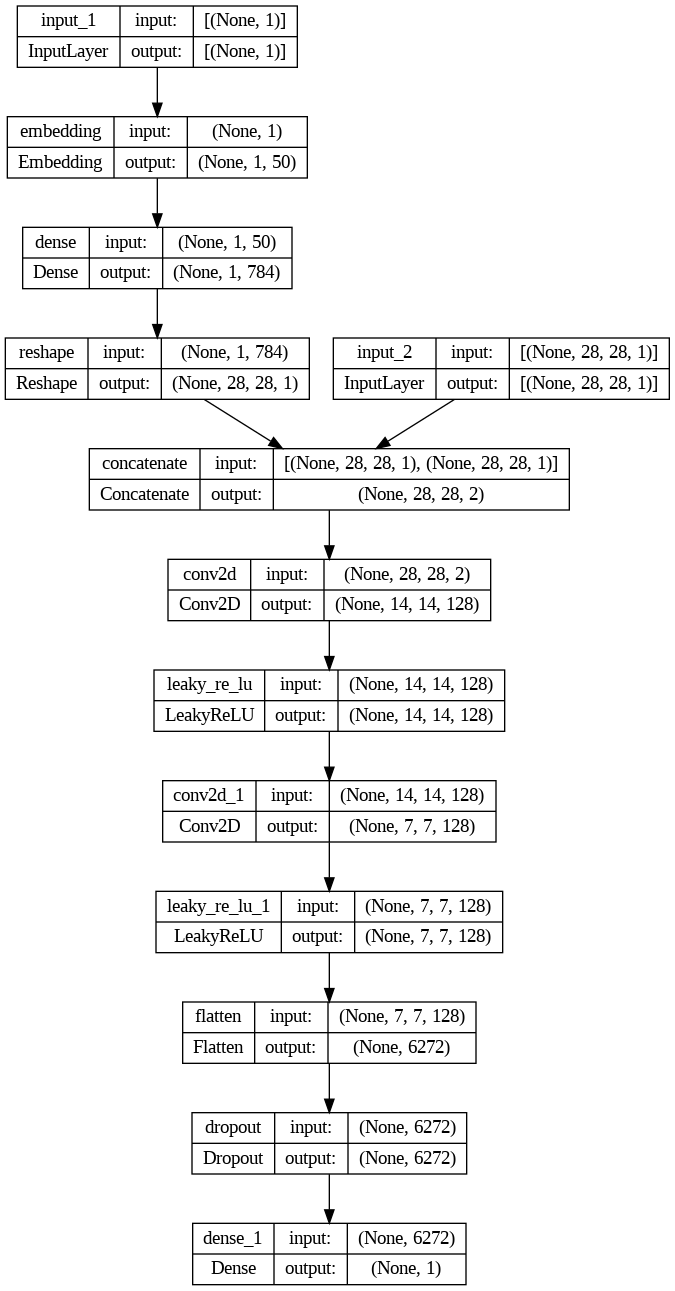

In [ ]:
def define_discriminator_model(in_shape = (28,28,1), n_classes = 10):
  in_label = Input(shape=(1,))
  # embedding for categorical input
  li = Embedding(n_classes, 50)(in_label)
  # scale up to image dimensions with linear activation
  n_nodes = in_shape[0] * in_shape[1]
  li = Dense(n_nodes)(li)
  # reshape to additional channel
  li = Reshape((in_shape[0], in_shape[1], 1))(li)
  # image input
  in_image = Input(shape=in_shape)
  # concat label as a channel
  merge = Concatenate()([in_image, li])
  # downsample
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
  fe = LeakyReLU(alpha=0.2)(fe)
  # downsample
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  # flatten feature maps
  fe = Flatten()(fe)
  # dropout
  fe = Dropout(0.4)(fe)
  # output
  out_layer = Dense(1, activation='sigmoid')(fe)
  # define model
  model = Model([in_image, in_label], out_layer)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model
discriminator = define_discriminator_model()
discriminator.summary()
plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

## Generator Changes

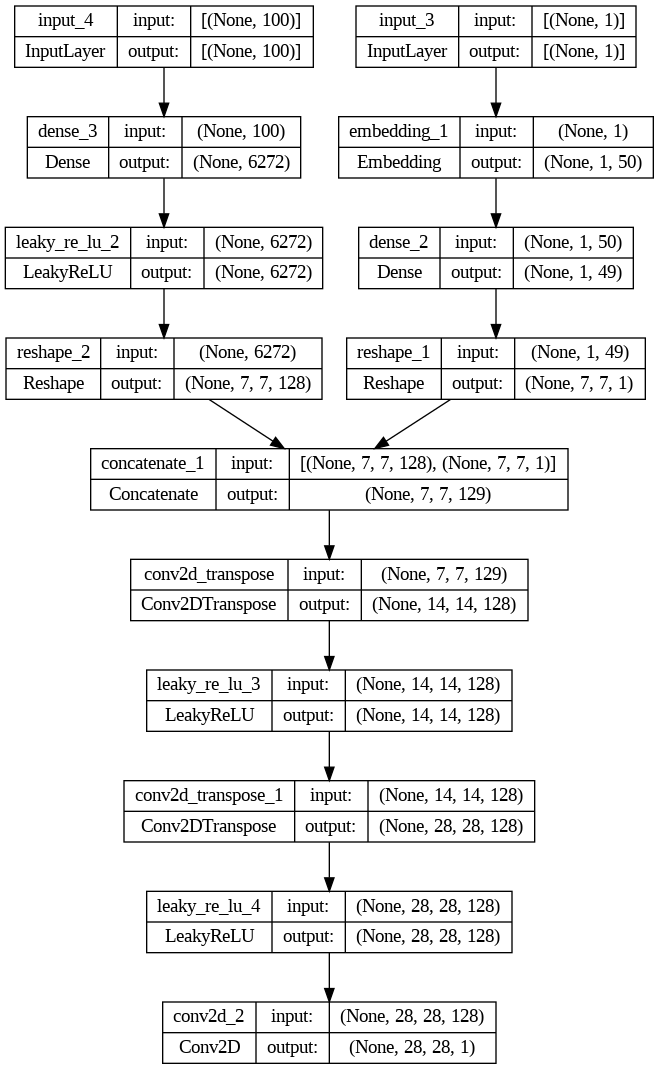

In [ ]:
def define_generator(latent_dim, n_classes=10):
  in_label = Input(shape=(1,))
  # embedding for categorical input
  li = Embedding(n_classes, 50)(in_label)
  # linear multiplication
  n_nodes = 7 * 7
  li = Dense(n_nodes)(li)
  # reshape to additional channel
  li = Reshape((7, 7, 1))(li)
  # image generator input
  in_lat = Input(shape=(latent_dim,))
  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  gen = Dense(n_nodes)(in_lat)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Reshape((7, 7, 128))(gen)
  # merge image gen and label input
  merge = Concatenate()([gen, li])
  # upsample to 14x14
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
  gen = LeakyReLU(alpha=0.2)(gen)
  # upsample to 28x28
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # output
  out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
  # define model
  model = Model([in_lat, in_label], out_layer)
  return model
generator = define_generator(100)
plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

## GAN Model Changes

In [ ]:
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  # get noise and label inputs from generator model
  gen_noise, gen_label = g_model.input
  # get image output from the generator model
  gen_output = g_model.output
  # connect image output and label input from generator as inputs to discriminator
  gan_output = d_model([gen_output, gen_label])
  # define gan model as taking noise and label and outputting a classification
  model = Model([gen_noise, gen_label], gan_output)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model


## Preprocessing Changes

In [ ]:
def load_real_samples():
  # load dataset
  (trainX, trainy), (_, _) = load_data()
  # expand to 3d, e.g. add channels
  X = expand_dims(trainX, axis=-1)
  # convert from ints to floats
  X = X.astype('float32')
  # scale from [0,255] to [0,1]
  X = X/255.0
  return [X, trainy]
# select real samples
def generate_real_samples(dataset, n_samples):
  # split into images and labels
  images, labels = dataset
  # choose random instances
  ix = randint(0, images.shape[0], n_samples)
  # select images and labels
  X, labels = images[ix], labels[ix]
  # generate class labels
  y = ones((n_samples, 1))
  return [X, labels], y

def generate_latent_points(latent_dim, n_samples, n_classes=10):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  z_input = x_input.reshape(n_samples, latent_dim)
  # generate labels
  labels = randint(0, n_classes, n_samples)
  return [z_input, labels]

def generate_fake_samples(generator, latent_dim, n_samples):
  # generate points in latent space
  z_input, labels_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  images = generator.predict([z_input, labels_input])
  # create class labels
  y = zeros((n_samples, 1))
  return [images, labels_input], y


## Training the CGAN

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=60, n_batch=128):
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected ✬real✬ samples
      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      # generate ✬fake✬ examples
      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
      # prepare points in latent space as input for the generator
      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator✬s error
      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
      (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
  g_model.save('cgan_generator.h5')
latent_dim = 100
# create the discriminator
d_model = define_discriminator_model()
# create the generator
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 11ms/step
>55, 309/468, d1=0.217, d2=0.827 g=3.256
2/2 [==============================] - 0s 10ms/step
>55, 310/468, d1=0.666, d2=0.155 g=2.863
2/2 [==============================] - 0s 8ms/step
>55, 311/468, d1=0.238, d2=0.512 g=3.346
2/2 [==============================] - 0s 9ms/step
>55, 312/468, d1=0.640, d2=0.204 g=2.617
2/2 [==============================] - 0s 11ms/step
>55, 313/468, d1=0.147, d2=0.741 g=3.138
2/2 [==============================] - 0s 12ms/step
>55, 314/468, d1=0.528, d2=0.112 g=2.909
2/2 [==============================] - 0s 5ms/step
>55, 315/468, d1=0.325, d2=0.610 g=2.870
2/2 [==============================] - 0s 6ms/step
>55, 316/468, d1=0.466, d2=0.176 g=2.582
2/2 [==============================] - 0s 4ms/step
>55, 317/468, d1=0.328, d2=0.228 g=2.588
2/2 [==============================] - 0s 6ms/step
>55, 318/468, d1=0.206, d2=0.253 g=3.612
2/2 [====================

>60, 468/468, d1=0.166, d2=0.612 g=2.871


## Testing

4/4 [==============================] - 0s 18ms/step


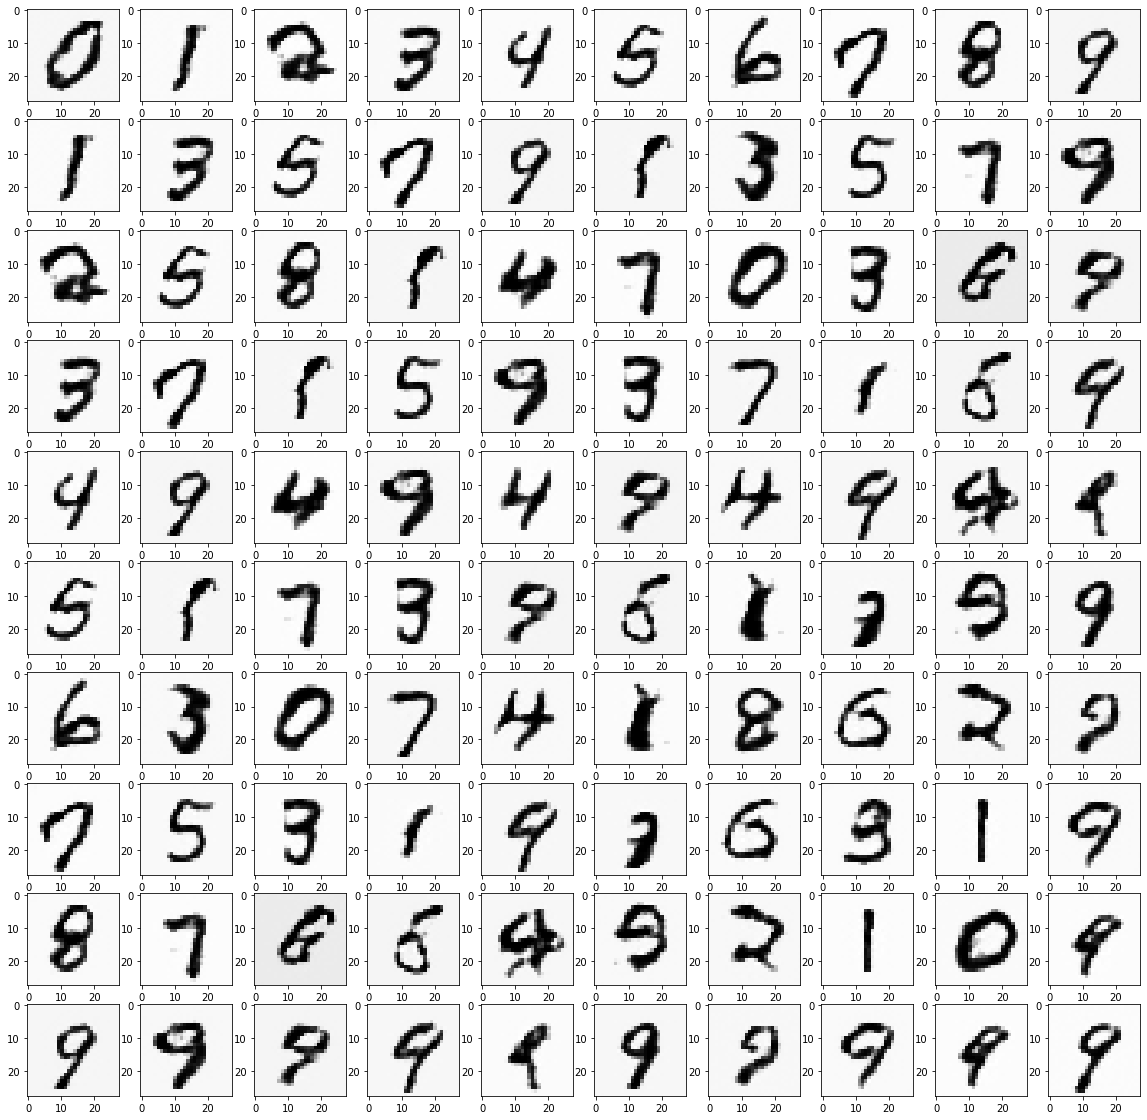

In [ ]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot as plt
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  z_input = x_input.reshape(n_samples, latent_dim)
  # generate labels
  labels = randint(0, n_classes, n_samples)
  return [z_input, labels]
# create and save a plot of generated images
def save_plot(examples, n):
  fig, ax = plt.subplots(ncols = 10,nrows=10,figsize = (20,20))
  for i in range(10):
    for j in range(10):
      ax[i][j].imshow(examples[(i+1)*(j+1)-1, :, :, 0], cmap = 'gray_r')
# load model
model = load_model('cgan_generator.h5')
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
# plot the result
X = (X + 1) / 2.0

save_plot(X, 10)
